# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [147]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns

## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [2]:
df = CSV.read("data/section10.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ、白丸は生存確率0.504の二項分布

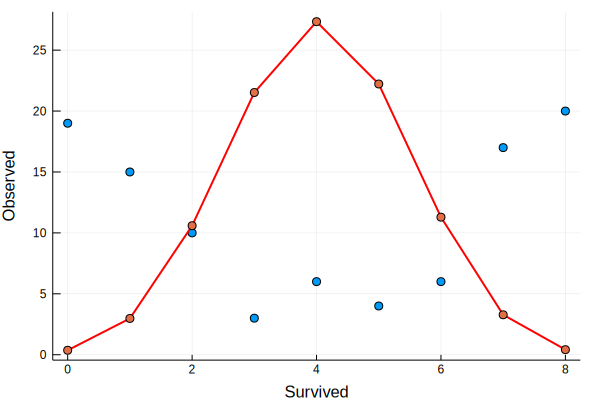

In [3]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング

In [94]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]


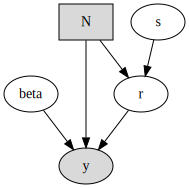

In [95]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

In [96]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

In [97]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0496439, 0.011459, 0.0778968, 0.00609671, 0.138471, 0.0837114, -0.0293935, -0.104615, 0.0460503, -0.0636275  …  -0.0616358, -0.0258657, 0.00356665, -0.0546469, -0.0374702, -0.139389, 0.0275838, -0.128626, -0.0143878, 0.0541543])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.107265, -0.106143, -0.164341, -0.064856, 0.0920922, 0.0309841, 0.122395, 0.138679, -0.0084376, -0.0539538  …  0.110448, 0.0948965, -0.0141668, -0.00618124, 0.0878355, -0.149685, -0.0324758, -0.110322, 0.0757148, 0.0235893])     
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.157334, -0.0143586, -0.0581181, 0.173259, 0.0579055, 0.118514, -0.0110412, -0.00485835, 0.0459292, 0.159767  …  -0.0409423, -0.0509424, 0.0329744, -0.0577562, 0.140414, -0.080596, 0.0544292, 0.0142635, -0.

In [98]:
scheme = [
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                           
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

In [99]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 20000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 20000 Iterations x 3 Chains...

Chain 1:   0% [0:02:54 of 0:02:54 remaining]
Chain 1:  10% [0:01:47 of 0:01:59 remaining]
Chain 1:  20% [0:01:34 of 0:01:58 remaining]
Chain 1:  30% [0:01:23 of 0:01:58 remaining]
Chain 1:  40% [0:01:11 of 0:01:59 remaining]
Chain 1:  50% [0:00:59 of 0:01:58 remaining]
Chain 1:  60% [0:00:47 of 0:01:58 remaining]
Chain 1:  70% [0:00:35 of 0:01:58 remaining]
Chain 1:  80% [0:00:24 of 0:01:58 remaining]
Chain 1:  90% [0:00:12 of 0:01:58 remaining]
Chain 1: 100% [0:00:00 of 0:01:58 remaining]

Chain 2:   0% [0:02:05 of 0:02:06 remaining]
Chain 2:  10% [0:01:50 of 0:02:02 remaining]
Chain 2:  20% [0:01:35 of 0:01:59 remaining]
Chain 2:  30% [0:01:24 of 0:01:60 remaining]
Chain 2:  40% [0:01:13 of 0:02:01 remaining]
Chain 2:  50% [0:01:00 of 0:02:00 remaining]
Chain 2:  60% [0:00:48 of 0:01:59 remaining]
Chain 2:  70% [0:00:36 of 0:01:59 remaining]
Chain 2:  80% [0:00:24 of 0:01:58 remaining]
Chain 2:  90% [0:00:12 of 0:01:58 remaining]
Cha

Object of type "ModelChains"

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

[3.03997 -2.65654 … -5.49314 0.375817; 2.87271 -4.75402 … -4.01256 0.383892; … ; 3.03546 -5.97749 … -3.62418 -0.141344; 3.02354 -7.27849 … -2.33043 0.135079]

[2.68721 -3.24497 … -6.02367 0.0334398; 3.19301 -4.76504 … -9.22643 0.190959; … ; 3.44952 -4.48236 … -5.64351 0.458672; 3.27812 -4.95544 … -5.56601 0.847515]

[2.5282 -3.14532 … -3.02979 -0.165824; 2.52109 -4.43791 … -2.26146 0.00134261; … ; 3.15068 -1.31384 … -5.0672 -0.164683; 3.56463 -4.01359 … -4.07447 -0.0558291]

In [100]:
describe(sim)

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

Empirical Posterior Estimates:
           Mean         SD       Naive SE       MCSE        ESS   
     s  3.047540196 0.37437113 0.0049586668 0.0077426311 1900.0000
  r[1] -3.878047298 1.77836818 0.0235550619 0.0294527861 1900.0000
  r[2] -1.205587653 0.90027621 0.0119244496 0.0150685164 1900.0000
  r[3]  1.995223096 1.11175180 0.0147255124 0.0192355919 1900.0000
  r[4]  3.800631750 1.73693056 0.0230062073 0.0269522300 1900.0000
  r[5] -2.083713874 1.09590447 0.0145156094 0.0185206800 1900.0000
  r[6]  2.000879800 1.10364113 0.0146180839 0.0190296887 1900.0000
  r[7]  3.823553261 1.76760953 0.0234125602 0.0222482829 1900.0000
  r[8]  3.818736936 1.78006830 0.0235775806 0.0292390524 1900.0000
  r[9] -2.089827252 1.13661501 0.0150548336 0.0183439601 1900.0000
 r[10] -2.060466916 1.08043048 0.0143106513 0.0171569238 1900.0000
 r[11] -0.029556194 0.79677766 0.0105535779 0.0155044471 1900.0000
 r[12] -3.

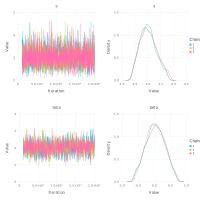

In [21]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

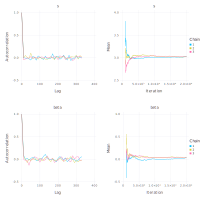

In [22]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

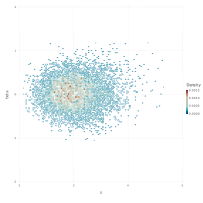

In [13]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測

In [124]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

In [125]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

In [144]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

5700-element Array{Array{Float64,1},1}:
 [0.185295, 0.0972806, 0.0733242, 0.0647189, 0.0632394, 0.0676387, 0.0806243, 0.114868, 0.253011]
 [0.173034, 0.098392, 0.076006, 0.0678282, 0.0666154, 0.0713104, 0.0846281, 0.11862, 0.243566]   
 [0.194658, 0.112321, 0.0855615, 0.0748653, 0.0718028, 0.0746093, 0.0849366, 0.110909, 0.190336] 
 [0.221559, 0.09854, 0.070465, 0.060535, 0.0581664, 0.061557, 0.0730568, 0.10504, 0.25108]       
 [0.169428, 0.082813, 0.0622277, 0.0554823, 0.0551406, 0.0604495, 0.0748846, 0.114989, 0.324585] 
 [0.186787, 0.0911563, 0.0677159, 0.0596428, 0.0584912, 0.0631098, 0.0764904, 0.113032, 0.283575]
 [0.213907, 0.090819, 0.0647929, 0.0559398, 0.0542108, 0.0580882, 0.0702938, 0.105001, 0.286947] 
 [0.243365, 0.105528, 0.0741196, 0.0627337, 0.0594202, 0.0619034, 0.0720205, 0.100312, 0.220597] 
 [0.213379, 0.105172, 0.0768559, 0.0663576, 0.0636128, 0.0667516, 0.0778407, 0.107543, 0.222488] 
 [0.210587, 0.0967522, 0.0700354, 0.0606216, 0.0585931, 0.0623371, 0.0743805, 

In [146]:
sum([0.185295, 0.0972806, 0.0733242, 0.0647189, 0.0632394, 0.0676387, 0.0806243, 0.114868, 0.253011])

1.0000000999999998

In [145]:
rand(Distributions.Categorical([0.185295, 0.0972806, 0.0733242, 0.0647189, 0.0632394, 0.0676387, 0.0806243, 0.114868, 0.253011]), 100) .- 1

ArgumentError: ArgumentError: Categorical: the condition isprobvec(p) is not satisfied.

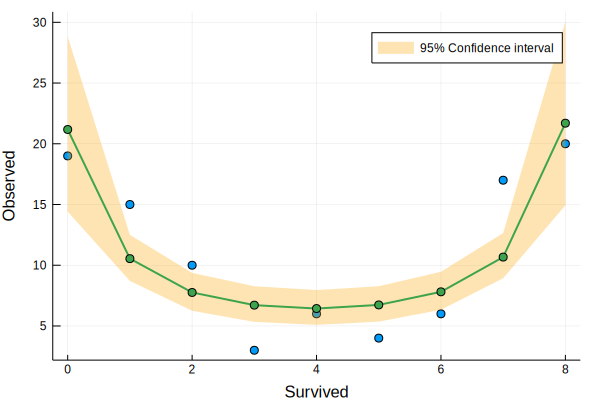

In [31]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile.(posterior, 0.975) * 100, lw = 0, 
        fillrange = quantile.(posterior, 0.025) * 100, fillalpha = 0.3, fillcolor = :orange,
        label = "95% Confidence interval")
Plots.plot!(0:8, median.(posterior) * 100, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")

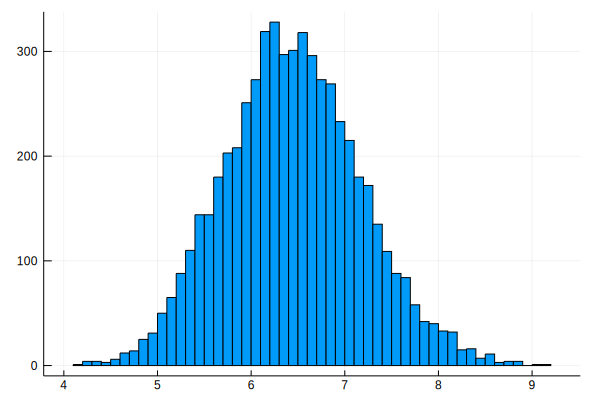

In [36]:
histogram(100 .* d_gaussian_binorm.(4, sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:]), label = "")